In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32927/status,
Dashboard: /proxy/32927/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33449,Workers: 4
Dashboard: /proxy/32927/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.132:36281,Total threads: 4
Dashboard: /proxy/33451/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:43585,


In [3]:
session = cc.database.create_session()

In [4]:
# load the MOM6 data
db='/g/data/ik11/outputs/mom6-panan/panant.db' 
expts = ['panant-v2','panant-hycom1','panant-01-zstar']

In [5]:
# get the depth
depth = cc.querying.getvar('panant-v2','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [6]:
# time period
start_time = '1996-01-01'
end_time = '1997-01-01'
# set the threshold of density(AABW)
rho_AABW = 1037.125

In [7]:
# load ACCESS-OM2 streamfunction psi(x,y,rho,t)
expt = '1deg_jra55v13_iaf_spinup1_B1'
flux1 = cc.querying.getvar(expt,'tx_trans_rho',session,start_time=start_time,end_time=end_time)

# AABW flux for the whole time series
flux1 = flux1.sel(potrho = slice(rho_AABW,2000.)).sel(time = slice(start_time,end_time))

# annual mean AABW streamfunction
flux1_AABW = flux1.mean('time').cumsum('grid_yt_ocean').sum('potrho')/1e9

#load the calculation
flux1_AABW = flux1_AABW.load()

In [8]:
# load ACCESS-OM2-025 streamfunction psi(x,y,rho,t)
expt = '025deg_jra55_iaf_omip2_cycle1'
flux2 = cc.querying.getvar(expt,'tx_trans_rho',session,start_time = start_time,end_time=end_time)

# flux of AABW for the whole time series
flux2 = flux2.sel(potrho = slice(rho_AABW,2000.)).sel(time = slice(start_time,end_time))

# calculate the streamfunction of AABW
flux2_AABW = flux2.mean('time').cumsum('grid_yt_ocean').sum('potrho')/1e9

# load the data
flux2_AABW = flux2_AABW.load()

In [9]:
# load ACCESS-OM2-01 streamfunction psi(x,y,rho,t)
expt = '01deg_jra55v13_iaf'
flux3 = cc.querying.getvar(expt,'tx_trans_rho', session, start_time=start_time, end_time=end_time)

# flux of AABW for the whole time series
flux3 = flux3.sel(potrho = slice(rho_AABW,2000.)).sel(time = slice(start_time,end_time))

# calculate the streamfunction of AABW
flux3_AABW = flux3.mean('time').cumsum('grid_yt_ocean').sum('potrho')/1e9

# load the data
flux3_AABW=flux3_AABW.load()

In [10]:
# load MOM6 streamfunction 
flux4 = cc.querying.getvar('panant-v2','umo',session)

flux4 = flux4.sel(rho2_l = slice(rho_AABW,2000.)).sel(time = slice(start_time,end_time))

# calculate the psi of AABW
flux4_AABW = flux4.mean('time').cumsum('yh').sum('rho2_l')/1e9
flux4_AABW = flux4_AABW.load()

Text(0, 0.5, 'Streamfunction (Sv)')

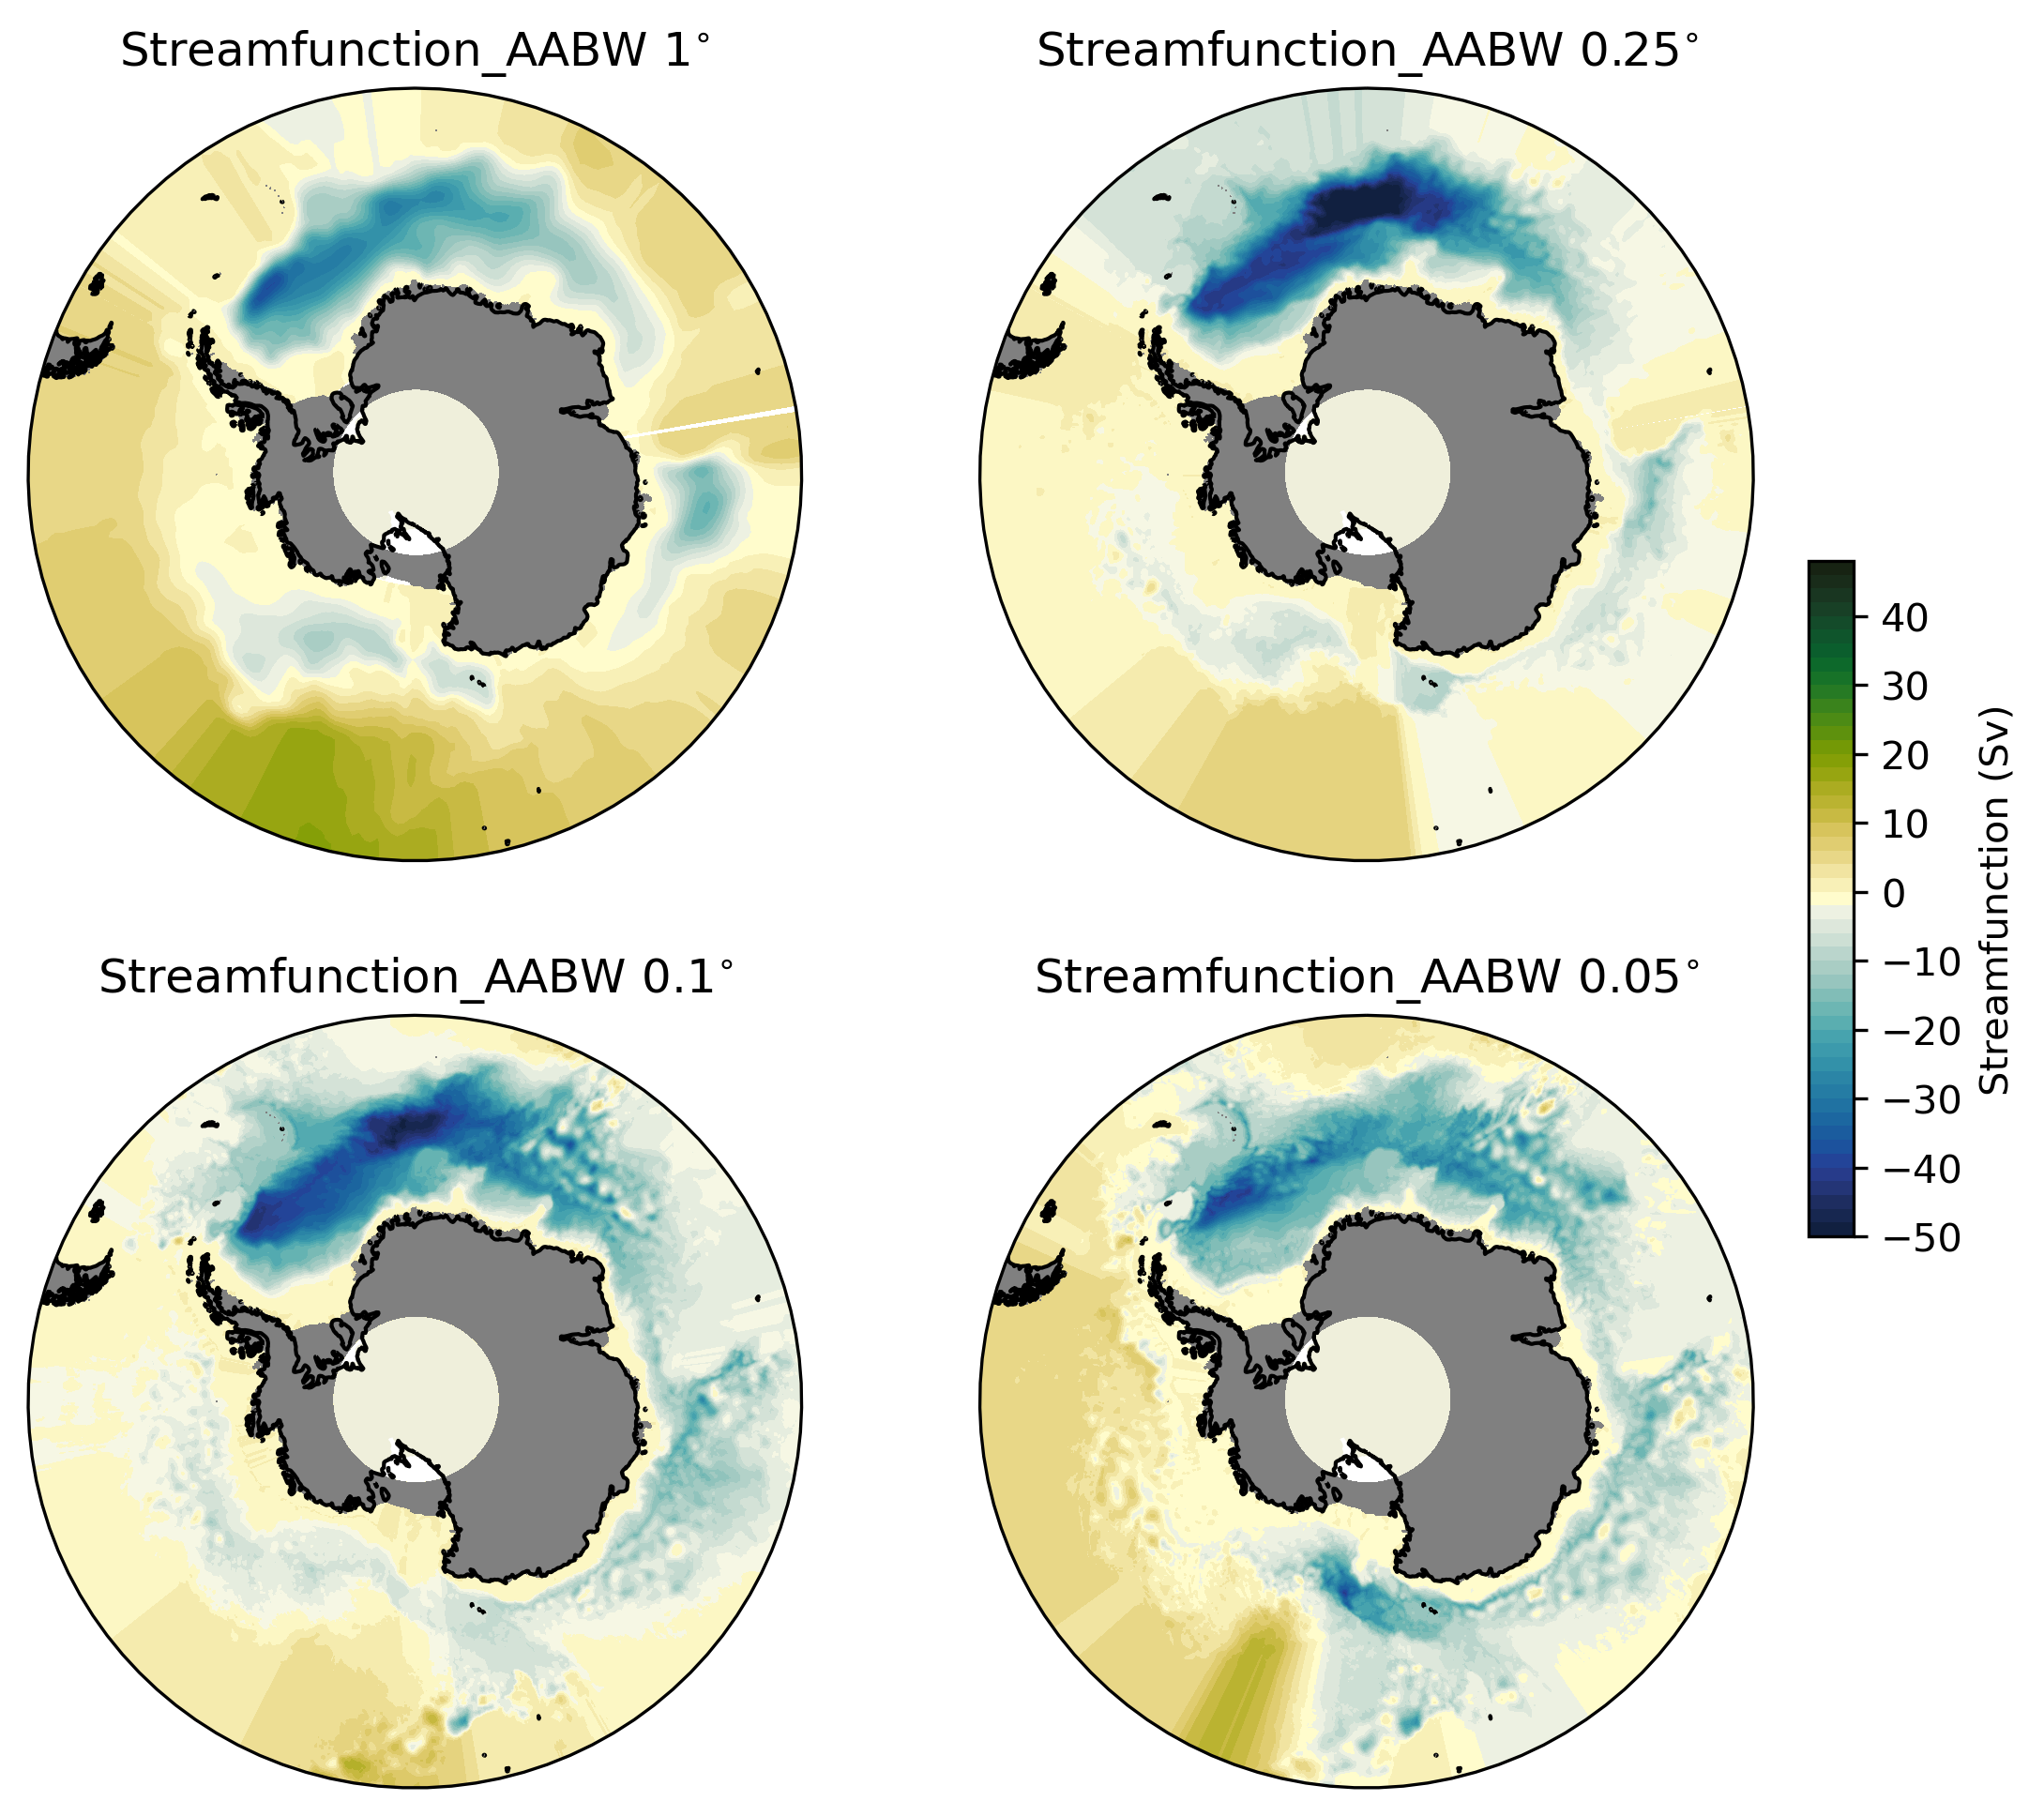

In [12]:
# plot
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=300)
# 1 deg
ax = plt.subplot(2,2,1,projection = projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta),np.cos(theta)]).T
circle = mpath.Path(verts *radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux1_AABW.plot.contourf(ax=ax, levels = np.arange(-50,50,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.delta,add_colorbar=False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('Streamfunction_AABW 1$^{\circ}$')

#0.25 deg
ax = plt.subplot(2,2,2, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -50], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform = ax.transAxes)
p1 = flux2_AABW.plot.contourf(ax=ax, levels=np.arange(-50,50,2),transform = ccrs.PlateCarree(),
                              cmap=cm.cm.delta,add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform = ccrs.PlateCarree(),colors = 'grey')
ax.set_title('Streamfunction_AABW 0.25$^{\circ}$')

# 0.1 deg
ax = plt.subplot(2, 2, 3, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -50], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux3_AABW.plot.contourf(ax=ax,levels=np.arange(-50,50,2),transform=ccrs.PlateCarree(),
                      cmap=cm.cm.delta,add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('Streamfunction_AABW 0.1$^{\circ}$')

# 0.05 deg
ax = plt.subplot(2,2,4, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50],crs=ccrs.PlateCarree())

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = flux4_AABW.plot.contourf(ax=ax, levels = np.arange(-50,50,2),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.delta,add_colorbar = False)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
ax.set_title('Streamfunction_AABW 0.05$^{\circ}$')

# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend='neither')
cb.ax.set_ylabel('Streamfunction (Sv)')